## Importing librires

In [1]:
%matplotlib inline

import os
import zipfile
#import tensorflow as tf
#from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from shutil import copyfile

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

Was imported "PetImages" folder in data folder.

In [2]:
!wget --no-check-certificate \
  "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats and dogs.zip"

local_zip = '/tmp/cats and dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') #reding file
zip_ref.extractall('/content')
zip_ref.close()

--2023-10-19 15:55:51--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.25.248.114, 2600:1413:b000:78a::317f, 2600:1413:b000:793::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.25.248.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats and dogs.zip’

/tmp/cats and dogs. 100%[===================>] 786.67M   151MB/s    in 5.5s    

2023-10-19 15:55:57 (144 MB/s) - ‘/tmp/cats and dogs.zip’ saved [824887076/824887076]



In [2]:
!ls #listing files in the folder

 CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'   sample_data


In [2]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:] # considering just the name. The structure considere folder, subfolder and images

print(categories)

['PetImages/Dog', 'PetImages/Cat']


In [4]:
#counting files
for dir in categories:
  print("Folder: ", dir)
  initial_count = 0
  for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
      initial_count += 1
  print(f"There are {initial_count} files")

Folder:  PetImages/Dog
There are 12501 files
Folder:  PetImages/Cat
There are 12501 files


In [3]:
# helper function to load image and return it and input vector
def get_image(path):
  img = image.load_img(path, target_size=(299, 299)) # resizing image to 299 (according with inception v3 model)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  if type(x) is np.ndarray:
    return img, x
  else:
    print("File that isn't array:", path)
    print(f"\n tipo de x: {type(x)}")

Load all the images from root folder

In [4]:
data = []
for c, category in enumerate(categories):
  print(f"Category: {category} / Label:{c}")
  # c is the number of category
  # category is the name - e.g: 101_ObjectCategories/sunflower
  images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(category) for f in filenames
              # method walk() generates the file names in a directory tree by walking the tree
              # dp: eg. 101_ObjectCategories/anchor
              # dn: []
              # filenames: ['image_0018.jpg', 'image_0001.jpg', ...]
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
  # images is a vector with folder/subfolder/image --> eg.: 101_ObjectCategories/anchor/image_0018.jpg'
  images = images[0:1300] # limiting to processing
  for img_path in images:
    if os.path.splitext(img_path)[1].lower() in ['.jpg','.png','.jpeg'] and os.path.getsize(img_path) > 0:
      img, x = get_image(img_path) #function created previosly
      #x = get_image(img_path) #function created previosly
      #print(img)
      #print(x)
          #img: return <PIL.Image.Image image mode=RGB size=224x224 at 0x7E99492ED120>
          #x: array with values from RGB
      data.append({'x':np.array(x[0]), 'y':c})
    else:
      print("File's size", os.path.getsize(img_path)) #pass

# count the number of classes
num_classes = len(categories)
print(f"We have {num_classes} categories")

Category: PetImages/Dog / Label:0
Category: PetImages/Cat / Label:1
We have 2 categories


Randomize the data order.

In [5]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [6]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [7]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [8]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 2600 images from 2 categories
train / validation / test split: 1819, 391, 390
training data shape:  (1819, 299, 299, 3)
training labels shape:  (1819, 2)


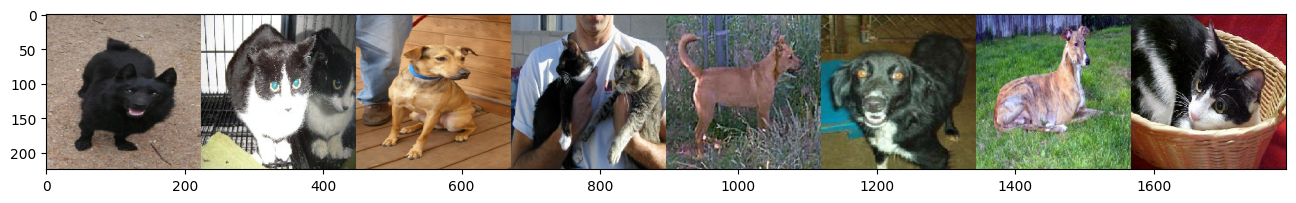

In [11]:
# Verifying if images were correctly uploaded
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Transfer learning by starting with existing network

Transfer learning considering inception_v3 from keras, which was trained on ImageNet and the weights saved online.
Follow the image with resume of model (for more datails [click here](https://paperswithcode.com/method/inception-v3))
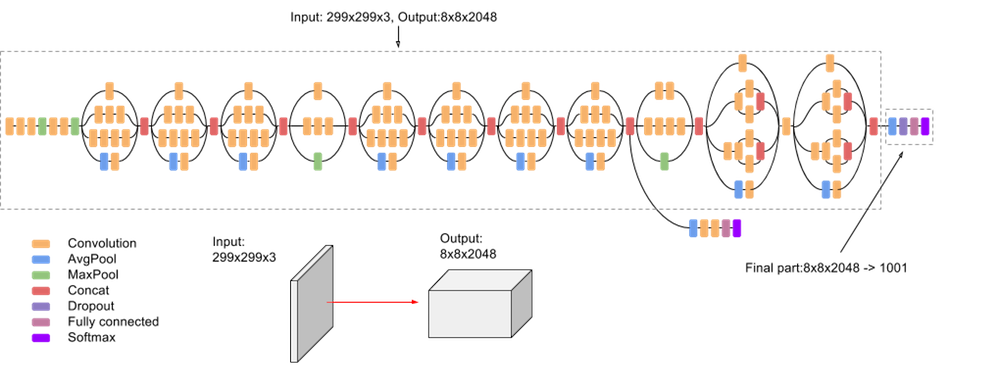

In [9]:
inception = keras.applications.InceptionV3(weights='imagenet', include_top= True)
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

Was "remove" the final classification layer and instead replace it with a new softmax layer for our dataset, which contains 2 neurons in the case of the Cat vs Dog dataset.

In [10]:
# make a reference to inception_V3's input layer
inp = inception.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(inception.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

Retrain this network, `model_new` on the new dataset and labels.

In [11]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [12]:
history = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
15/15 [==============================] - 37s 1s/step - loss: 0.4041 - accuracy: 0.8378 - val_loss: 0.1600 - val_accuracy: 0.9795
Epoch 2/10
15/15 [==============================] - 10s 642ms/step - loss: 0.1116 - accuracy: 0.9797 - val_loss: 0.0796 - val_accuracy: 0.9821
Epoch 3/10
15/15 [==============================] - 9s 575ms/step - loss: 0.0670 - accuracy: 0.9874 - val_loss: 0.0634 - val_accuracy: 0.9821
Epoch 4/10
15/15 [==============================] - 10s 653ms/step - loss: 0.0524 - accuracy: 0.9896 - val_loss: 0.0532 - val_accuracy: 0.9847
Epoch 5/10
15/15 [==============================] - 10s 669ms/step - loss: 0.0445 - accuracy: 0.9896 - val_loss: 0.0486 - val_accuracy: 0.9847
Epoch 6/10
15/15 [==============================] - 10s 673ms/step - loss: 0.0414 - accuracy: 0.9918 - val_loss: 0.0476 - val_accuracy: 0.9872
Epoch 7/10
15/15 [==============================] - 10s 684ms/step - loss: 0.0364 - accuracy: 0.9907 - val_loss: 0.0421 - val_accuracy: 0.9872
Epo

Below will be plot the validation loss and accuracy again

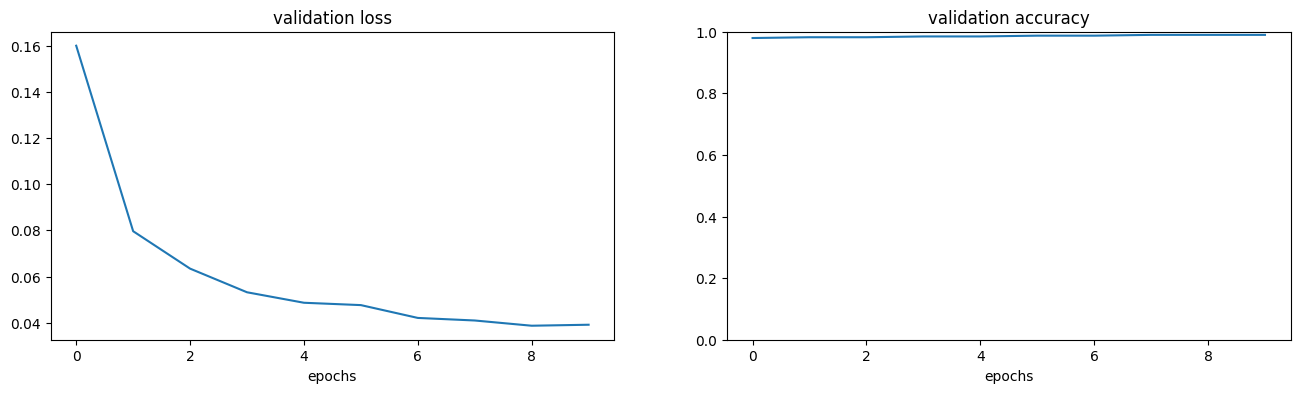

In [13]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Final validation on the test set.

In [14]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.029270049184560776
Test accuracy: 0.9923076629638672


To predict a new image, simply run the following code to get the probabilities for each class.

In [15]:
img, x = get_image('PetImages/Dog/7.jpg')
probabilities = model_new.predict([x])


1/1 [==============================] - 2s 2s/step


In [17]:
img, x = get_image('PetImages/Dog/8.jpg')
probabilities = model_new.predict([x])
probabilities

1/1 [==============================] - 0s 27ms/step


array([[1.0000000e+00, 1.0968108e-16]], dtype=float32)